In [1]:
! pip install pandas
! pip install torch
! pip install transformers


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
! pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 31.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 39.8 MB/s eta 0:00:0000:0100:01


training with 323_combined_dataset.csv

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/323_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Example: Convert to tensors if using PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

class PolymerDataset(Dataset):
    def __init__(self, properties, smiles):
        self.properties = properties
        self.smiles = smiles
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        return self.properties.iloc[idx].values, self.smiles[idx]

dataset = PolymerDataset(properties, smiles_strings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Model Fine-Tuning

In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

# Define the number of epochs and maximum length
num_epochs = 10  # Adjust this number based on your training needs
max_length = 128  # Adjust this based on your dataset

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Example: Convert to tensors if using PyTorch
class PolymerDataset(Dataset):
    def __init__(self, properties, smiles):
        self.properties = properties
        self.smiles = smiles
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        return self.properties.iloc[idx].values, self.smiles[idx]

dataset = PolymerDataset(properties, smiles_strings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Extend tokenizer to handle property input (optional, for custom tokens)
additional_tokens = [f"<prop_{i}>" for i in range(properties.shape[1])]
tokenizer.add_tokens(additional_tokens)
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_tokens = [f"<prop_{i}>" for i, prop in enumerate(properties)]
    prop_ids = tokenizer.convert_tokens_to_ids(prop_tokens)
    return prop_ids

# Fine-tuning loop
model.train()
for epoch in range(num_epochs):
    for props, smiles in dataloader:
        prop_ids = [encode_properties(p, tokenizer) for p in props]
        
        # Tokenize SMILES strings
        inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        
        # Concatenate property tokens with SMILES tokens
        input_ids = []
        attention_masks = []
        for i in range(len(inputs['input_ids'])):
            combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
            # Pad the combined input to max_length
            combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * (max_length - len(combined_input))
            input_ids.append(combined_input)
            # Create an attention mask
            attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
            attention_mask = attention_mask[:max_length] + [0] * (max_length - len(attention_mask))
            attention_masks.append(attention_mask)

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Save the fine-tuned model
model.save_pretrained('polymer_gpt')

/home/dion/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dion/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dion/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 2.8042354583740234
Epoch 2, Loss: 1.2820357084274292
Epoch 3, Loss: 0.9140259623527527
Epoch 4, Loss: 1.0331207513809204
Epoch 5, Loss: 0.7158473134040833
Epoch 6, Loss: 0.6795881986618042
Epoch 7, Loss: 0.6818895936012268
Epoch 8, Loss: 0.549263596534729
Epoch 9, Loss: 0.4778783917427063
Epoch 10, Loss: 0.3516653776168823


Generating SMILES Strings

In [1]:
model.eval()

def generate_smiles(properties, tokenizer, model, max_length=50):
    prop_ids = encode_properties(properties, tokenizer)
    input_ids = torch.tensor([prop_ids])
    
    # Generate SMILES string
    outputs = model.generate(input_ids, max_length=max_length, num_return_sequences=1)
    smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return smiles

# Example usage
example_properties = [4.18,0.5629,3.5157]  # Replace with actual property values
generated_smiles = generate_smiles(example_properties, tokenizer, model)
print(f"Generated SMILES: {generated_smiles}")

NameError: name 'model' is not defined

/home/dion/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dion/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Train Loss: 6.4135, Test Loss: 1.7020
Epoch 2, Train Loss: 1.7938, Test Loss: 1.4466
Epoch 3, Train Loss: 1.5176, Test Loss: 1.2619
Epoch 4, Train Loss: 1.3591, Test Loss: 1.1902
Epoch 5, Train Loss: 1.2634, Test Loss: 1.0885
Epoch 6, Train Loss: 1.1720, Test Loss: 1.0268
Epoch 7, Train Loss: 1.0931, Test Loss: 0.9548
Epoch 8, Train Loss: 1.0082, Test Loss: 0.8843
Epoch 9, Train Loss: 0.9408, Test Loss: 0.8145
Epoch 10, Train Loss: 0.8903, Test Loss: 0.7647
Epoch 11, Train Loss: 0.8377, Test Loss: 0.7198
Epoch 12, Train Loss: 0.7838, Test Loss: 0.6864
Epoch 13, Train Loss: 0.7532, Test Loss: 0.6648
Epoch 14, Train Loss: 0.7250, Test Loss: 0.6477
Epoch 15, Train Loss: 0.6986, Test Loss: 0.6362
Epoch 16, Train Loss: 0.6767, Test Loss: 0.6226
Epoch 17, Train Loss: 0.6630, Test Loss: 0.6192
Epoch 18, Train Loss: 0.6473, Test Loss: 0.6117
Epoch 19, Train Loss: 0.6430, Test Loss: 0.6073
Epoch 20, Train Loss: 0.6424, Test Loss: 0.6049
Epoch 21, Train Loss: 0.6345, Test Loss: 0.5980
E

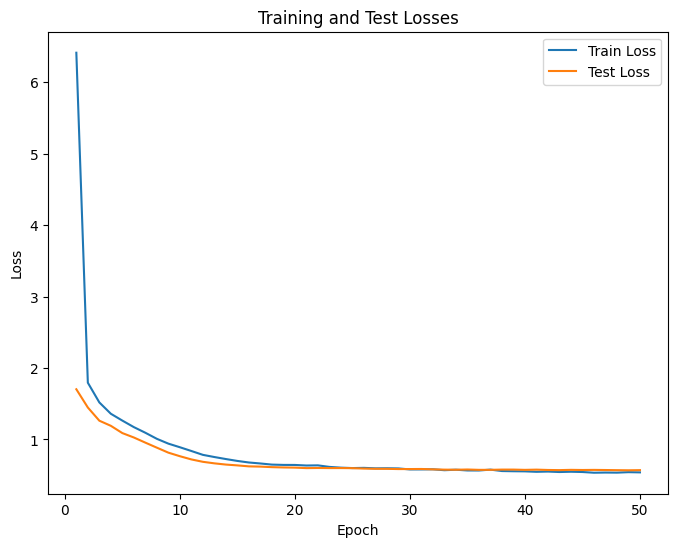

Generated SMILES: 4.18 0.5629 3.5157 4.8255 6.0451 1.907 nan*Cc1ccc(C(=O)c2ccc(*)s2)cc1


In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/323_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Split the data into training and testing sets
train_properties, test_properties, train_smiles, test_smiles = train_test_split(
    properties, smiles_strings, test_size=0.2, random_state=42
)

# Define the dataset class
class PolymerDataset(Dataset):
    def __init__(self, properties, smiles):
        self.properties = properties.reset_index(drop=True)
        self.smiles = smiles.reset_index(drop=True)
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        return self.properties.iloc[idx].values, self.smiles.iloc[idx]

# Create datasets and dataloaders
train_dataset = PolymerDataset(train_properties, train_smiles)
test_dataset = PolymerDataset(test_properties, test_smiles)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Extend tokenizer to handle property input
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Function to encode properties as strings
def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_text = ' '.join([str(prop) for prop in properties])
    prop_ids = tokenizer.encode(prop_text, add_special_tokens=False)
    return prop_ids

# Training parameters
num_epochs = 50
max_length = 128

train_losses = []
test_losses = []

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for props, smiles in train_dataloader:
        prop_ids = [encode_properties(p, tokenizer) for p in props.numpy()]
        
        # Tokenize SMILES strings
        inputs = tokenizer(list(smiles), return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        
        # Concatenate property tokens with SMILES tokens
        input_ids = []
        attention_masks = []
        for i in range(len(inputs['input_ids'])):
            combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
            # Pad the combined input to max_length
            combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * (max_length - len(combined_input))
            input_ids.append(combined_input)
            # Create an attention mask
            attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
            attention_mask = attention_mask[:max_length] + [0] * (max_length - len(attention_mask))
            attention_masks.append(attention_mask)
    
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
    
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for props, smiles in test_dataloader:
            prop_ids = [encode_properties(p, tokenizer) for p in props.numpy()]
            
            # Tokenize SMILES strings
            inputs = tokenizer(list(smiles), return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            
            # Concatenate property tokens with SMILES tokens
            input_ids = []
            attention_masks = []
            for i in range(len(inputs['input_ids'])):
                combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
                # Pad the combined input to max_length
                combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * (max_length - len(combined_input))
                input_ids.append(combined_input)
                # Create an attention mask
                attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
                attention_mask = attention_mask[:max_length] + [0] * (max_length - len(attention_mask))
                attention_masks.append(attention_mask)
        
            input_ids = torch.tensor(input_ids)
            attention_masks = torch.tensor(attention_masks)
        
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
            loss = outputs.loss
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Plot training and test losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

# Save the fine-tuned model
model.save_pretrained('polymer_gpt_323')

# Define the generate_smiles function
def generate_smiles(properties, tokenizer, model, max_length=50):
    prop_ids = encode_properties(properties, tokenizer)
    input_ids = torch.tensor([prop_ids])
    
    # Generate SMILES string
    outputs = model.generate(
        input_ids, 
        max_length=max_length, 
        num_return_sequences=1, 
        pad_token_id=tokenizer.eos_token_id
    )
    smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return smiles

# Example usage
model.eval()
example_properties = [4.18, 0.5629, 3.5157]  # Replace with actual property values
generated_smiles = generate_smiles(example_properties, tokenizer, model)
print(f"Generated SMILES: {generated_smiles}")


In [7]:
# Define the generate_smiles function
def generate_smiles(properties, tokenizer, model, max_length=50):
    prop_ids = encode_properties(properties, tokenizer)
    input_ids = torch.tensor([prop_ids])
    
    # Generate SMILES string
    outputs = model.generate(
        input_ids, 
        max_length=max_length, 
        num_return_sequences=1, 
        pad_token_id=tokenizer.eos_token_id
    )
    smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return smiles

# Example usage
model.eval()
example_properties = [3, 0.7, 1, 7]  # Replace with actual property values
generated_smiles = generate_smiles(example_properties, tokenizer, model)
print(f"Generated SMILES: {generated_smiles}")

Generated SMILES: 3 0.7 1 7.907 4.8672 5.907 1.9128 nan*Cc1ccc(C(=O)c2ccc(*)s2)cc1


## Now trying to produce mulitple (10) strings at the same time

/home/dion/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dion/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dion/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 11.3387, Validation Loss: 2.4633
Epoch 2, Training Loss: 2.3563, Validation Loss: 1.7125
Epoch 3, Training Loss: 1.4582, Validation Loss: 1.0588
Epoch 4, Training Loss: 1.0601, Validation Loss: 0.8293
Epoch 5, Training Loss: 0.8467, Validation Loss: 0.6656
Epoch 6, Training Loss: 0.7696, Validation Loss: 0.6124
Epoch 7, Training Loss: 0.6885, Validation Loss: 0.5499
Epoch 8, Training Loss: 0.6133, Validation Loss: 0.5142
Epoch 9, Training Loss: 0.5752, Validation Loss: 0.4582
Epoch 10, Training Loss: 0.5443, Validation Loss: 0.4228


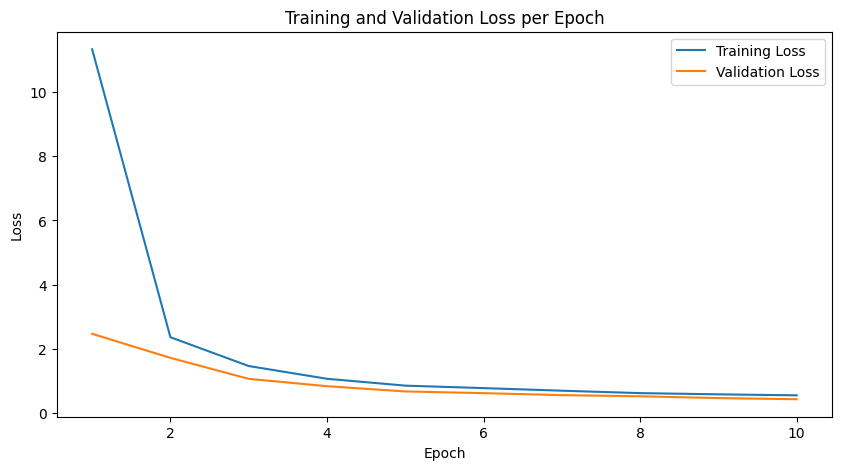


Generated SMILES strings based on test set properties:
Sample 1:
Properties: [4.09   2.874  2.3058 2.7965 5.6687 1.9675    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> (ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc

Sample 2:
Properties: [3.82   1.0659 4.0591 4.5017 5.578  1.8539    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> (ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc

Sample 3:
Properties: [7.36   3.7029 2.0371 3.4559 7.159  2.102     nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> (ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc

Sample 4:
Properties: [7.44   3.2278 1.5224 2.5282 5.7571 2.5812    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> (ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc1ccc

Sample 5:
Properties: [3.58   1.482  3.7492 4.2048 5.6867 1.872     nan]
Generated SMILES: <prop_0> <prop_1> <pr

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import torch.nn as nn

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/323_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Split the dataset into training and test sets
properties_train, properties_test, smiles_train, smiles_test = train_test_split(
    properties, smiles_strings, test_size=0.2, random_state=42
)

# Define the PolymerDataset class
class PolymerDataset(Dataset):
    def __init__(self, properties, smiles):
        self.properties = properties.reset_index(drop=True)
        self.smiles = smiles.reset_index(drop=True)
            
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        return self.properties.iloc[idx].values, self.smiles.iloc[idx]

# Create datasets and dataloaders for training and test sets
dataset_train = PolymerDataset(properties_train, smiles_train)
dataset_test = PolymerDataset(properties_test, smiles_test)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Extend tokenizer to handle property input (optional, for custom tokens)
additional_tokens = [f"<prop_{i}>" for i in range(properties.shape[1])]
tokenizer.add_tokens(additional_tokens)
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 10  # Adjust this number based on your training needs
max_length = 128  # Adjust this based on your dataset

def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_tokens = [f"<prop_{i}>" for i in range(len(properties))]
    prop_ids = tokenizer.convert_tokens_to_ids(prop_tokens)
    return prop_ids

# Initialize lists to store losses
train_losses = []
val_losses = []

# Fine-tuning loop
model.train()
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # Training loop
    for props, smiles in dataloader_train:
        prop_ids = [encode_properties(p, tokenizer) for p in props]
        
        # Tokenize SMILES strings
        inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        
        # Concatenate property tokens with SMILES tokens
        input_ids = []
        attention_masks = []
        for i in range(len(inputs['input_ids'])):
            combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
            # Pad the combined input to max_length
            combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
            input_ids.append(combined_input)
            # Create an attention mask
            attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
            attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
            attention_masks.append(attention_mask)

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for props, smiles in dataloader_test:
            prop_ids = [encode_properties(p, tokenizer) for p in props]
            
            # Tokenize SMILES strings
            inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            
            # Concatenate property tokens with SMILES tokens
            input_ids = []
            attention_masks = []
            for i in range(len(inputs['input_ids'])):
                combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
                # Pad the combined input to max_length
                combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
                input_ids.append(combined_input)
                # Create an attention mask
                attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
                attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
                attention_masks.append(attention_mask)

            input_ids = torch.tensor(input_ids)
            attention_masks = torch.tensor(attention_masks)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
            loss = outputs.loss

            total_val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(dataloader_train)
    avg_val_loss = total_val_loss / len(dataloader_test)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    model.train()  # Switch back to training mode

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Save the fine-tuned model
model.save_pretrained('polymer_gpt_323')

# Function to generate SMILES strings
def generate_smiles(properties, tokenizer, model, max_length=50):
    prop_ids = encode_properties(properties, tokenizer)
    input_ids = torch.tensor([prop_ids])
    
    # Generate SMILES string
    outputs = model.generate(input_ids, max_length=max_length, num_return_sequences=1, 
                             pad_token_id=tokenizer.pad_token_id, 
                             eos_token_id=tokenizer.eos_token_id)
    smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return smiles

# Generate SMILES strings for 10 samples from the test set
model.eval()
print("\nGenerated SMILES strings based on test set properties:")
for i in range(10):
    test_properties = properties_test.iloc[i].values
    generated_smiles = generate_smiles(test_properties, tokenizer, model)
    print(f"Sample {i+1}:")
    print(f"Properties: {test_properties}")
    print(f"Generated SMILES: {generated_smiles}\n")


### train #2: 50 epochs

/home/dion/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dion/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dion/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 18.4958, Validation Loss: 4.3792
Epoch 2, Training Loss: 4.1265, Validation Loss: 3.1299
Epoch 3, Training Loss: 3.1023, Validation Loss: 2.2734
Epoch 4, Training Loss: 2.4553, Validation Loss: 2.0042
Epoch 5, Training Loss: 2.0721, Validation Loss: 1.6249
Epoch 6, Training Loss: 1.6741, Validation Loss: 1.2143
Epoch 7, Training Loss: 1.3579, Validation Loss: 1.1015
Epoch 8, Training Loss: 1.1807, Validation Loss: 0.9679
Epoch 9, Training Loss: 1.0077, Validation Loss: 0.8115
Epoch 10, Training Loss: 0.8819, Validation Loss: 0.6851
Epoch 11, Training Loss: 0.7898, Validation Loss: 0.6173
Epoch 12, Training Loss: 0.7035, Validation Loss: 0.5487
Epoch 13, Training Loss: 0.6538, Validation Loss: 0.5077
Epoch 14, Training Loss: 0.6023, Validation Loss: 0.4641
Epoch 15, Training Loss: 0.5813, Validation Loss: 0.4338
Epoch 16, Training Loss: 0.5470, Validation Loss: 0.4177
Epoch 17, Training Loss: 0.5364, Validation Loss: 0.3938
Epoch 18, Training Loss: 0.4904, Valida

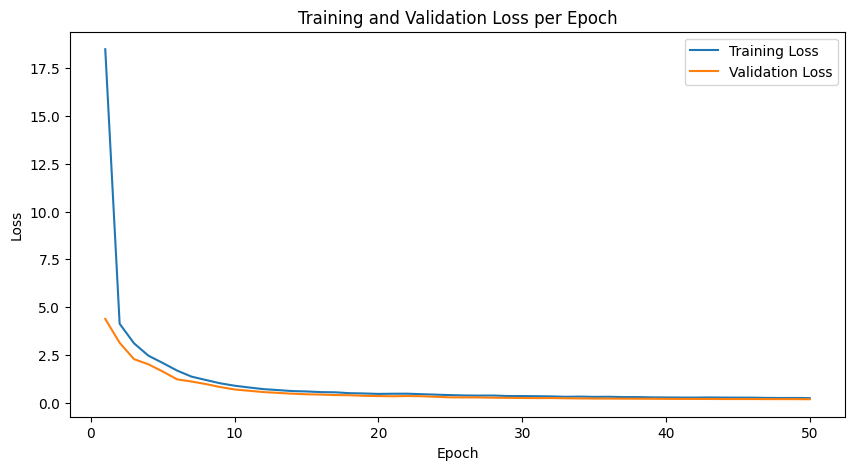

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import torch.nn as nn

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/323_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Split the dataset into training and test sets
properties_train, properties_test, smiles_train, smiles_test = train_test_split(
    properties, smiles_strings, test_size=0.2, random_state=42
)

# Define the PolymerDataset class
class PolymerDataset(Dataset):
    def __init__(self, properties, smiles):
        self.properties = properties.reset_index(drop=True)
        self.smiles = smiles.reset_index(drop=True)
            
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        return self.properties.iloc[idx].values, self.smiles.iloc[idx]

# Create datasets and dataloaders for training and test sets
dataset_train = PolymerDataset(properties_train, smiles_train)
dataset_test = PolymerDataset(properties_test, smiles_test)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Extend tokenizer to handle property input (optional, for custom tokens)
additional_tokens = [f"<prop_{i}>" for i in range(properties.shape[1])]
tokenizer.add_tokens(additional_tokens)
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50  # Adjust this number based on your training needs
max_length = 128  # Adjust this based on your dataset

def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_tokens = [f"<prop_{i}>" for i in range(len(properties))]
    prop_ids = tokenizer.convert_tokens_to_ids(prop_tokens)
    return prop_ids

# Initialize lists to store losses
train_losses = []
val_losses = []

# Fine-tuning loop
model.train()
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # Training loop
    for props, smiles in dataloader_train:
        prop_ids = [encode_properties(p, tokenizer) for p in props]
        
        # Tokenize SMILES strings
        inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        
        # Concatenate property tokens with SMILES tokens
        input_ids = []
        attention_masks = []
        for i in range(len(inputs['input_ids'])):
            combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
            # Pad the combined input to max_length
            combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
            input_ids.append(combined_input)
            # Create an attention mask
            attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
            attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
            attention_masks.append(attention_mask)

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for props, smiles in dataloader_test:
            prop_ids = [encode_properties(p, tokenizer) for p in props]
            
            # Tokenize SMILES strings
            inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            
            # Concatenate property tokens with SMILES tokens
            input_ids = []
            attention_masks = []
            for i in range(len(inputs['input_ids'])):
                combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
                # Pad the combined input to max_length
                combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
                input_ids.append(combined_input)
                # Create an attention mask
                attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
                attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
                attention_masks.append(attention_mask)

            input_ids = torch.tensor(input_ids)
            attention_masks = torch.tensor(attention_masks)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
            loss = outputs.loss

            total_val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(dataloader_train)
    avg_val_loss = total_val_loss / len(dataloader_test)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    model.train()  # Switch back to training mode

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Save the fine-tuned model
model.save_pretrained('polymer_gpt_323')

In [2]:
# Function to generate SMILES strings
def generate_smiles(properties, tokenizer, model, max_length=50):
    prop_ids = encode_properties(properties, tokenizer)
    input_ids = torch.tensor([prop_ids])
    
    # Generate SMILES string
    outputs = model.generate(input_ids, max_length=max_length, num_return_sequences=1, 
                             pad_token_id=tokenizer.pad_token_id, 
                             eos_token_id=tokenizer.eos_token_id)
    smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return smiles

# Generate SMILES strings for 10 samples from the test set
model.eval()
print("\nGenerated SMILES strings based on test set properties:")
for i in range(10):
    test_properties = properties_test.iloc[i].values
    generated_smiles = generate_smiles(test_properties, tokenizer, model)
    print(f"Sample {i+1}:")
    print(f"Properties: {test_properties}")
    print(f"Generated SMILES: {generated_smiles}\n")


Generated SMILES strings based on test set properties:
Sample 1:
Properties: [4.09   2.874  2.3058 2.7965 5.6687 1.9675    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *Cc1ccc(C(=O)c2ccc(*)s2)s1

Sample 2:
Properties: [3.82   1.0659 4.0591 4.5017 5.578  1.8539    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *Cc1ccc(C(=O)c2ccc(*)s2)s1

Sample 3:
Properties: [7.36   3.7029 2.0371 3.4559 7.159  2.102     nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *Cc1ccc(C(=O)c2ccc(*)s2)s1

Sample 4:
Properties: [7.44   3.2278 1.5224 2.5282 5.7571 2.5812    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *Cc1ccc(C(=O)c2ccc(*)s2)s1

Sample 5:
Properties: [3.58   1.482  3.7492 4.2048 5.6867 1.872     nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *Cc1ccc(C(=O)c2ccc(*)s2)s1

Sample 6:
Properties: [4.55   2.39

# rerun 50 epochs with gpu

/home/dion/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/home/dion/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dion/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 8.3650, Validation Loss: 2.5688
Epoch 2, Training Loss: 1.9645, Validation Loss: 1.1460
Epoch 3, Training Loss: 1.2420, Validation Loss: 0.8632
Epoch 4, Training Loss: 1.0074, Validation Loss: 0.7516
Epoch 5, Training Loss: 0.9033, Validation Loss: 0.7041
Epoch 6, Training Loss: 0.8473, Validation Loss: 0.6675
Epoch 7, Training Loss: 0.7925, Validation Loss: 0.6142
Epoch 8, Training Loss: 0.7164, Validation Loss: 0.5820
Epoch 9, Training Loss: 0.6683, Validation Loss: 0.5436
Epoch 10, Training Loss: 0.6238, Validation Loss: 0.4989
Epoch 11, Training Loss: 0.5787, Validation Loss: 0.4660
Epoch 12, Training Loss: 0.5334, Validation Loss: 0.4359
Epoch 13, Training Loss: 0.5065, Validation Loss: 0.4087
Epoch 14, Training Loss: 0.4879, Validation Loss: 0.3859
Epoch 15, Training Loss: 0.4526, Validation Loss: 0.3728
Epoch 16, Training Loss: 0.4112, Validation Loss: 0.3569
Epoch 17, Training Loss: 0.3993, Validation Loss: 0.3428
Epoch 18, Training Loss: 0.3820, Validat

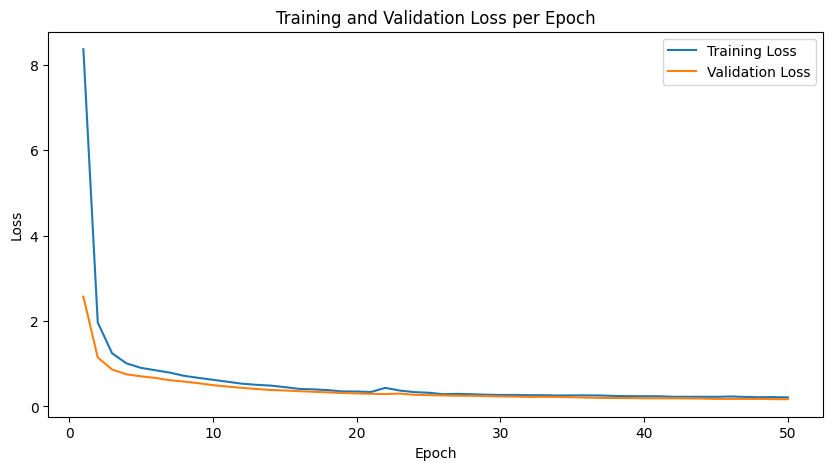

('polymer_gpt_323/tokenizer_config.json',
 'polymer_gpt_323/special_tokens_map.json',
 'polymer_gpt_323/vocab.json',
 'polymer_gpt_323/merges.txt',
 'polymer_gpt_323/added_tokens.json')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import torch.nn as nn

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/323_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Split the dataset into training and test sets
properties_train, properties_test, smiles_train, smiles_test = train_test_split(
    properties, smiles_strings, test_size=0.2, random_state=42
)

# Define the PolymerDataset class
class PolymerDataset(Dataset):
    def __init__(self, properties, smiles):
        self.properties = properties.reset_index(drop=True)
        self.smiles = smiles.reset_index(drop=True)
            
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        return self.properties.iloc[idx].values, self.smiles.iloc[idx]

# Create datasets and dataloaders for training and test sets
dataset_train = PolymerDataset(properties_train, smiles_train)
dataset_test = PolymerDataset(properties_test, smiles_test)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Extend tokenizer to handle property input (optional, for custom tokens)
additional_tokens = [f"<prop_{i}>" for i in range(properties.shape[1])]
tokenizer.add_tokens(additional_tokens)
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Move the model to the device
model.to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50  # Adjust this number based on your training needs
max_length = 128  # Adjust this based on your dataset

def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_tokens = [f"<prop_{i}>" for i in range(len(properties))]
    prop_ids = tokenizer.convert_tokens_to_ids(prop_tokens)
    return prop_ids

# Initialize lists to store losses
train_losses = []
val_losses = []

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()  # Switch to training mode
    total_train_loss = 0
    total_val_loss = 0

    # Training loop
    for props, smiles in dataloader_train:
        prop_ids = [encode_properties(p, tokenizer) for p in props]

        # Tokenize SMILES strings
        inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

        # Concatenate property tokens with SMILES tokens
        input_ids = []
        attention_masks = []
        for i in range(len(inputs['input_ids'])):
            combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
            # Pad the combined input to max_length
            combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
            input_ids.append(combined_input)
            # Create an attention mask
            attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
            attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
            attention_masks.append(attention_mask)

        input_ids = torch.tensor(input_ids).to(device)
        attention_masks = torch.tensor(attention_masks).to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    # Validation loop
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for props, smiles in dataloader_test:
            prop_ids = [encode_properties(p, tokenizer) for p in props]
            
            # Tokenize SMILES strings
            inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            
            # Concatenate property tokens with SMILES tokens
            input_ids = []
            attention_masks = []
            for i in range(len(inputs['input_ids'])):
                combined_input = prop_ids[i] + inputs['input_ids'][i].tolist()
                # Pad the combined input to max_length
                combined_input = combined_input[:max_length] + [tokenizer.pad_token_id] * max(0, max_length - len(combined_input))
                input_ids.append(combined_input)
                # Create an attention mask
                attention_mask = [1] * len(prop_ids[i]) + inputs['attention_mask'][i].tolist()
                attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
                attention_masks.append(attention_mask)

            input_ids = torch.tensor(input_ids).to(device)
            attention_masks = torch.tensor(attention_masks).to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)
            loss = outputs.loss

            total_val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(dataloader_train)
    avg_val_loss = total_val_loss / len(dataloader_test)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Save the fine-tuned model
model.save_pretrained('polymer_gpt_323')
tokenizer.save_pretrained('polymer_gpt_323')


using one gpu to train is much faster, decreasing the training time from more than 3 hours down to 4 min, 9.2second.

In [5]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the dataset
df = pd.read_csv('/home/dion/projects/New_TransPolymer/TransPolymer/Dion/data_Dion/323_combined_dataset.csv')
properties = df.drop(columns=['smiles'])
smiles_strings = df['smiles']

# Split the dataset into training and test sets
_, properties_test, _, smiles_test = train_test_split(
    properties, smiles_strings, test_size=0.2, random_state=42
)

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('polymer_gpt_323')
model = GPT2LMHeadModel.from_pretrained('polymer_gpt_323')

# Add the model to the appropriate device
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Define the encode_properties function
def encode_properties(properties, tokenizer):
    """Encode properties as token IDs."""
    prop_tokens = [f"<prop_{i}>" for i in range(len(properties))]
    prop_ids = tokenizer.convert_tokens_to_ids(prop_tokens)
    return prop_ids

# Define the function to generate SMILES strings
def generate_smiles(properties, tokenizer, model, max_length=50):
    prop_ids = encode_properties(properties, tokenizer)
    input_ids = torch.tensor([prop_ids]).to(device)
    
    # Generate SMILES string
    outputs = model.generate(
        input_ids, 
        max_length=max_length, 
        num_return_sequences=1, 
        pad_token_id=tokenizer.pad_token_id, 
        eos_token_id=tokenizer.eos_token_id
    )
    smiles = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return smiles

# Generate SMILES strings for 10 samples from the test set
print("\nGenerated SMILES strings based on test set properties:")
for i in range(5):
    test_properties = properties_test.iloc[i].values
    generated_smiles = generate_smiles(test_properties, tokenizer, model)
    print(f"Sample {i+1}:")
    print(f"Properties: {test_properties}")
    print(f"Generated SMILES: {generated_smiles}\n")


Using device: cuda

Generated SMILES strings based on test set properties:
Sample 1:
Properties: [4.09   2.874  2.3058 2.7965 5.6687 1.9675    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCCC(=O)O*

Sample 2:
Properties: [3.82   1.0659 4.0591 4.5017 5.578  1.8539    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCCC(=O)O*

Sample 3:
Properties: [7.36   3.7029 2.0371 3.4559 7.159  2.102     nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCCC(=O)O*

Sample 4:
Properties: [7.44   3.2278 1.5224 2.5282 5.7571 2.5812    nan]
Generated SMILES: <prop_0> <prop_1> <prop_2> <prop_3> <prop_4> <prop_5> <prop_6> *CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCCC(=O)O*

Sample 5:
Properties: [3.58   1.482  3.7492 4.2048 5.6867 1.872     nan]
Generated SMILES: <prop_0> <prop_1> <pro